In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('/home/matt/readout/host/')
import ali_offline_demod as dm
import ali_iv_analysis_2 as iv
import imp
import glob
import pickle
from scipy import spatial
import h5py
from scipy.fft import fft, ifft, fftfreq
from copy import deepcopy
from scipy.interpolate import CubicSpline, interp1d
from scipy.optimize import curve_fit
from tqdm.notebook import tqdm
import imp
import pandas as pd
from scipy.signal import savgol_filter as sg

/tmp/ipykernel_3443/3152699253.py:7: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
%matplotlib inline

looking for delay region


/home/matt/readout/host/ali_offline_demod.py:1393: RuntimeWarning: divide by zero encountered in log10
  y=np.append(y,20*np.log10(np.abs(test_sweep[1,:])))


start = 4521795898.4375
stop = 4531816406.25
delay: 3.5870965034905436e-08


/tmp/ipykernel_3443/1169243014.py:39: RuntimeWarning: divide by zero encountered in log10
  s21=np.append(s21,20*np.log10(np.abs(test_sweep[1,:])))


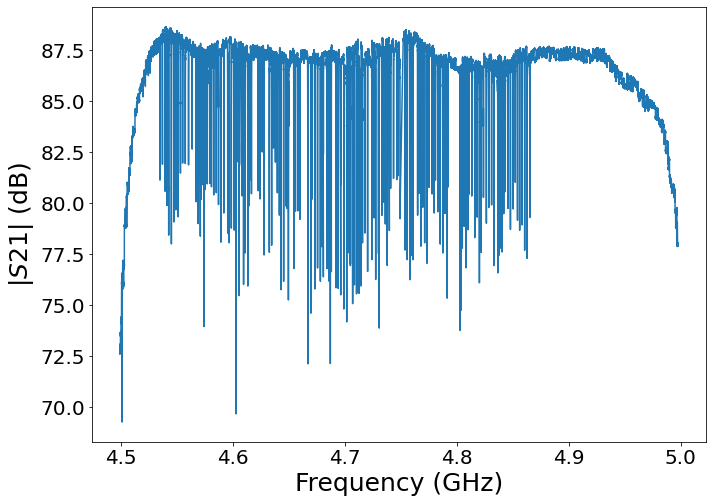

In [3]:
# Example 500 MHz LO Sweep

directory = '/home/matt/ali_drive_mnt'
lo_file = 'fcenter_4750.0_20240513180025'

def load_lo_sweep(directory_path):
    
    initial_lo_sweep_path = dm.find_file(directory_path, 'lo_sweep_initial')
    targeted_lo_sweep_path = dm.find_file(directory_path, 'lo_sweep_targeted_2')
    tone_freqs_path = dm.find_file(directory_path, 'freq_list_lo_sweep_targeted_1')    
    
    initial_lo_sweep=np.load(initial_lo_sweep_path) #find initial lo sweep file
    targeted_lo_sweep=np.load(targeted_lo_sweep_path) #find targeted sweep file
    tone_freqs=np.load(tone_freqs_path) #find tone freqs
    
    #compute delay region
    print('looking for delay region')
    delay_region_start, delay_region_stop = dm.find_freqs_cable_delay_subtraction(initial_lo_sweep,0.98,10000)
    print(f'start = {delay_region_start}')
    print(f'stop = {delay_region_stop}')
    
    #measure cable delay
    delays = dm.measure_delay_test_given_freq(initial_lo_sweep,delay_region_start,delay_region_stop,plot=False)
    
    print(f'delay: {np.median(delays)}')

    #remove cable delay
    targeted_lo_sweep_rm=dm.remove_delay(targeted_lo_sweep,
                                         np.median(delays))
    
    return initial_lo_sweep, targeted_lo_sweep, targeted_lo_sweep_rm, tone_freqs

def organize_lo_sweep(sweep_data):
    freq=[]
    s21=[]
    for i in range(sweep_data.shape[1]):
        test_sweep=sweep_data[:,i,:]
        freq=np.append(freq,test_sweep[0,:].real)
        s21=np.append(s21,20*np.log10(np.abs(test_sweep[1,:])))
        
    return freq, s21

initial_lo_sweep, targeted_lo_sweep, targeted_lo_sweep_rm, tone_freqs = load_lo_sweep(f'{directory}/tone_initializations/{lo_file}/')

freq, s21 = organize_lo_sweep(initial_lo_sweep)

#LO Example
fig, ax = plt.subplots(1,figsize=(11,8))
ax.plot(freq/10**9, s21)
ax.set_xlabel('Frequency (GHz)', fontsize = 25)
ax.set_ylabel('$|S21|$ (dB)', fontsize = 25)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig('./SPIE_2024_Figures/Example_LO_Sweep',dpi=120)

looking for delay region
start = 4404608687.500062
stop = 4414628218.750062
delay: 3.754490981227084e-08
looking for delay region
start = 4521795898.4375
stop = 4531816406.25
delay: 3.5870965034905436e-08
looking for delay region
start = 5119999187.500001
stop = 5130019695.312501
delay: 6.131385859532799e-08
looking for delay region
start = 5565131835.937551
stop = 5575152343.750051
delay: 6.593401371706546e-08
looking for delay region
start = 6143999039.062593
stop = 6154018570.312593
delay: 3.254070154191996e-08
looking for delay region
start = 6517287109.375
stop = 6527306640.625
delay: 3.065861003804136e-08


/tmp/ipykernel_3443/1169243014.py:39: RuntimeWarning: divide by zero encountered in log10
  s21=np.append(s21,20*np.log10(np.abs(test_sweep[1,:])))
/home/matt/.local/readout/lib/python3.10/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/home/matt/.local/readout/lib/python3.10/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


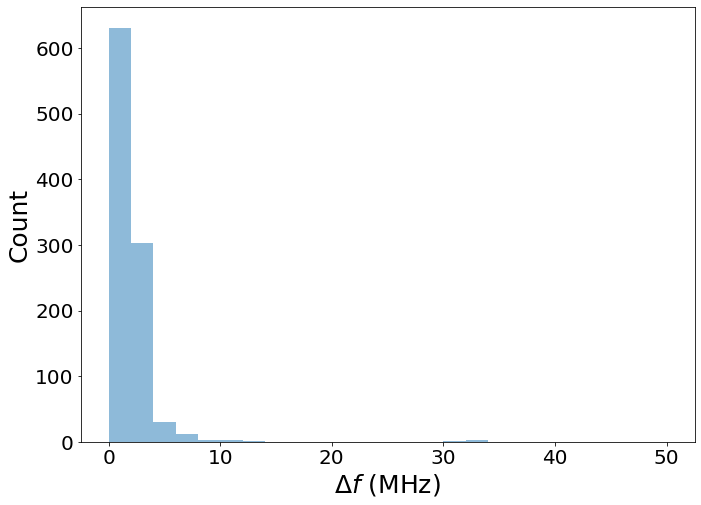

In [4]:
# Basic Resonator Stats

directory = '/home/matt/ali_drive_mnt'
lo_4250_file = 'fcenter_4250.0_20240513170334'
lo_4750_file = 'fcenter_4750.0_20240513180025'
lo_5250_file = 'fcenter_5250.0_20240513184433'
lo_5750_file = 'fcenter_5750.0_20240513191712'
lo_6250_file = 'fcenter_6250.0_20240513202622'
lo_6750_file = 'fcenter_6750.0_20240513204549'

initial_lo_sweep_4250, targeted_lo_sweep_4250, targeted_lo_sweep_rm_4250, tone_freqs_4250 = load_lo_sweep(f'{directory}/tone_initializations/{lo_4250_file}/')
initial_lo_sweep_4750, targeted_lo_sweep_4750, targeted_lo_sweep_rm_4750, tone_freqs_4750 = load_lo_sweep(f'{directory}/tone_initializations/{lo_4750_file}/')
initial_lo_sweep_5250, targeted_lo_sweep_5250, targeted_lo_sweep_rm_5250, tone_freqs_5250 = load_lo_sweep(f'{directory}/tone_initializations/{lo_5250_file}/')
initial_lo_sweep_5750, targeted_lo_sweep_5750, targeted_lo_sweep_rm_5750, tone_freqs_5750 = load_lo_sweep(f'{directory}/tone_initializations/{lo_5750_file}/')
initial_lo_sweep_6250, targeted_lo_sweep_6250, targeted_lo_sweep_rm_6250, tone_freqs_6250 = load_lo_sweep(f'{directory}/tone_initializations/{lo_6250_file}/')
initial_lo_sweep_6750, targeted_lo_sweep_6750, targeted_lo_sweep_rm_6750, tone_freqs_6750 = load_lo_sweep(f'{directory}/tone_initializations/{lo_6750_file}/')

freq_4250, s21_4250 = organize_lo_sweep(initial_lo_sweep_4250)
freq_4750, s21_4750 = organize_lo_sweep(initial_lo_sweep_4750)
freq_5250, s21_5250 = organize_lo_sweep(initial_lo_sweep_5250)
freq_5750, s21_5750 = organize_lo_sweep(initial_lo_sweep_5750)
freq_6250, s21_6250 = organize_lo_sweep(initial_lo_sweep_6250)
freq_6750, s21_6750 = organize_lo_sweep(initial_lo_sweep_6750)

full_tone_list = np.append(tone_freqs_4250, tone_freqs_4750)
full_tone_list = np.append(full_tone_list, tone_freqs_5250)
full_tone_list = np.append(full_tone_list, tone_freqs_5750)
full_tone_list = np.append(full_tone_list, tone_freqs_6250)
full_tone_list = np.append(full_tone_list, tone_freqs_6750)

tone_sep_4250 = np.diff(full_tone_list/10**6)

fig, ax = plt.subplots(1,figsize=(11,8))
ax.hist(tone_sep_4250, bins=25, range=(0,50),alpha=0.5)#histtype=u'step')
ax.set_xlabel('$\Delta f$ (MHz)',fontsize=25)
ax.set_ylabel('Count',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
fig.savefig('./SPIE_2024_Figures/Resonator_Separations',dpi=120)

/home/matt/.local/readout/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:651: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


700000 500000


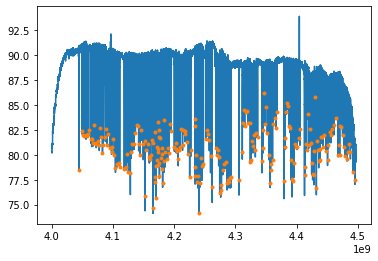

In [5]:
#come back to this - ask Maria if she has histogram of quality factors
resonator_interpolation_4250 = interp1d(freq_4250,s21_4250,fill_value='extrapolate')

freq_interp = np.linspace(4250e6-250e6,4250e6+250e6,700000)
s21_4250_interp = resonator_interpolation_4250(freq_interp)

plt.plot(freq_interp, s21_4250_interp)

freq_indices = [dm.find_nearest_idx(freq_interp, i) for i in tone_freqs_4250]

plt.plot(freq_interp[freq_indices],s21_4250_interp[freq_indices],'.')

print(len(freq_interp), len(freq_4250))

['./20240213_processed_load_curve_data/20240213_results_4750MHz_BL8_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_4250MHz_BL11_Cold.pkl', './20240213_processed_load_curve_data/20240213_results_4250MHz_BL10_Cold.pkl', './20240213_processed_load_curve_data/20240213_results_4750MHz_BL7_Cold.pkl', './20240213_processed_load_curve_data/20240213_results_6750MHz_BL12_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_4750MHz_BL7_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_5750MHz_BL8_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_6250MHz_BL8_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_4250MHz_BL11_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_6750MHz_BL12_Cold.pkl', './20240213_processed_load_curve_data/20240213_results_5750MHz_BL11_Cold.pkl', './20240213_processed_load_curve_data/20240213_results_4750MHz_BL9_Warm.pkl', './20240213_processed_load_curve_data/20240213_results_52

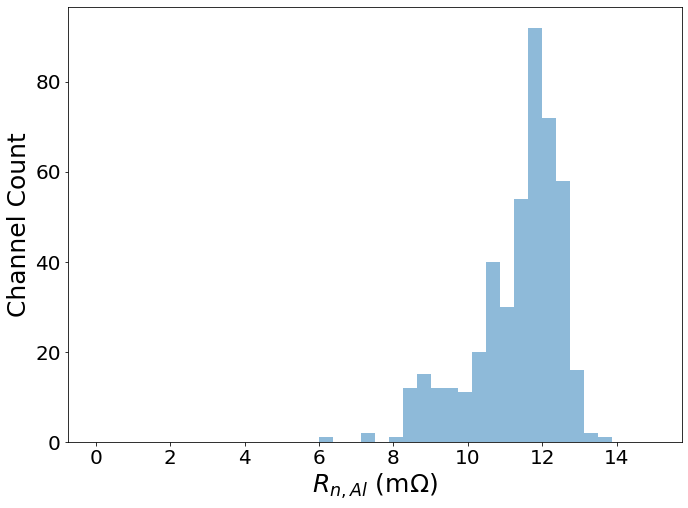

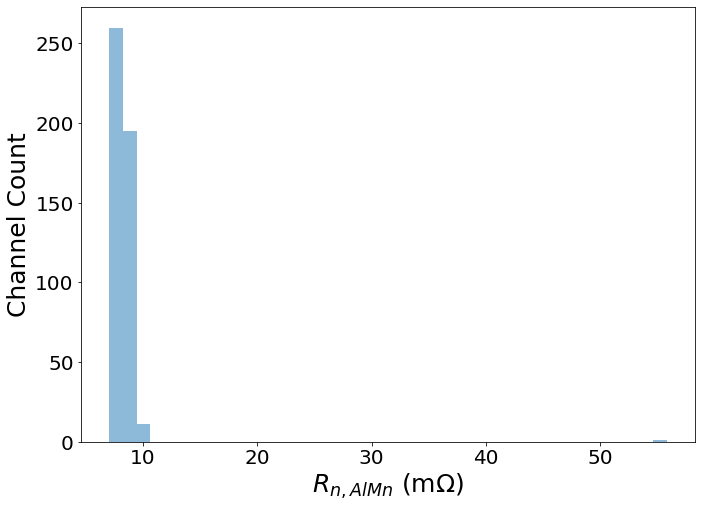

In [6]:
#module stats

#ASU numbering
#south line
GHz150_lines = [11,12,8,7] 
GHz95_lines = [10,9] 

datafiles = glob.glob('./20240213_processed_load_curve_data/[!testing]*')
print(datafiles)

Rn_Al = np.array([])
Rn_AlMn = np.array([])

for pickle_i in datafiles:
    print(pickle_i)
    temp = pickle_i.split('_')[-1].split('.')[0]
    ASU_BL = int(pickle_i.split('_')[-2].split('L')[1])
    
    #print(temp, ASU_BL)
    
    with open(pickle_i, 'rb') as f:
        data_i = pickle.load(f) 
        
    if temp == 'Warm':
        
        for ch in range(len(data_i['Vtes'])):
            Rn_Al = np.append(Rn_Al, data_i['Rn Al'][ch])
            Rn_AlMn = np.append(Rn_AlMn, data_i['Rn AlMn'][ch])
        
                                          
fig_Rn_Al, ax_Rn_Al = plt.subplots(1, figsize=(11,8))
ax_Rn_Al.hist(Rn_Al*1e3,bins=40,range=(0,15),alpha=0.5)#histtype=u'step')
ax_Rn_Al.set_xlabel('$R_{n,Al}$ (mΩ)',fontsize=25)
ax_Rn_Al.set_ylabel('Channel Count',fontsize=25)
ax_Rn_Al.tick_params(axis='both', which='major', labelsize=20)
fig_Rn_Al.savefig('./SPIE_2024_Figures/Rn_Al_Hist.png',dpi=150)
print(f'Rn Al mean: {np.nanmean(Rn_Al*1e3)} +- {np.nanstd(Rn_Al*1e3)}')


fig_Rn_AlMn, ax_Rn_AlMn = plt.subplots(1, figsize=(11,8))
ax_Rn_AlMn.hist(Rn_AlMn*1e3,bins=40,alpha=0.5)#histtype=u'step',range=(0,15))
ax_Rn_AlMn.set_xlabel('$R_{n,AlMn}$ (mΩ)',fontsize=25)
ax_Rn_AlMn.set_ylabel('Channel Count',fontsize=25)
ax_Rn_AlMn.tick_params(axis='both', which='major', labelsize=20)
fig_Rn_AlMn.savefig('./SPIE_2024_Figures/Rn_AlMn_Hist.png',dpi=150)
print(f'Rn AlMn mean: {np.nanmean(Rn_AlMn*1e3)} +- {np.nanstd(Rn_AlMn*1e3)}')
                

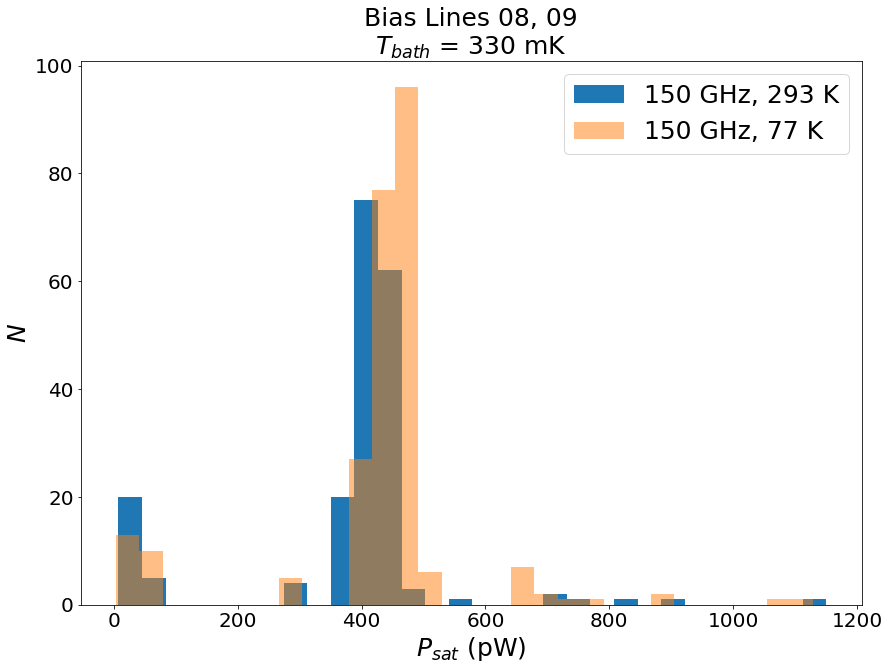

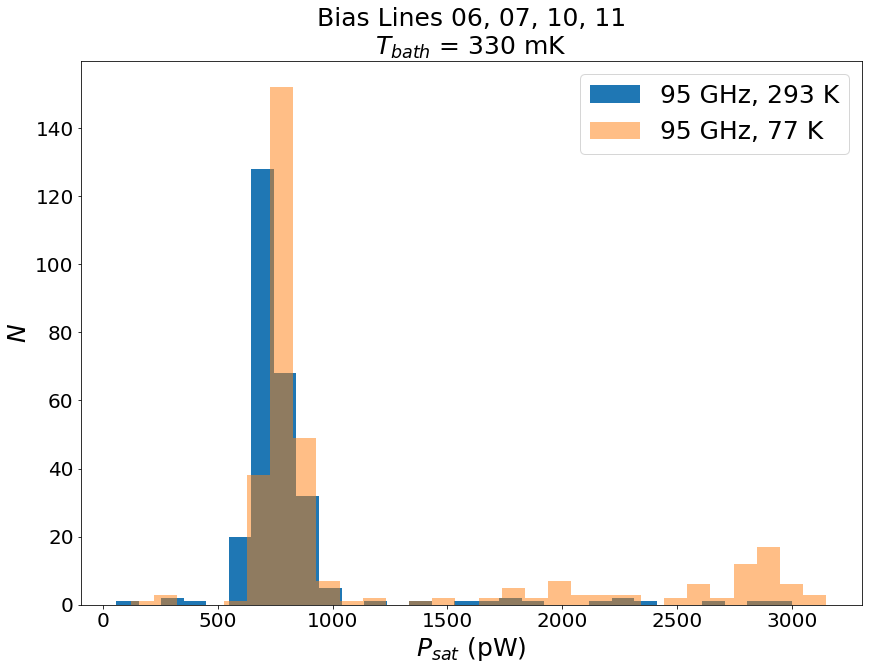

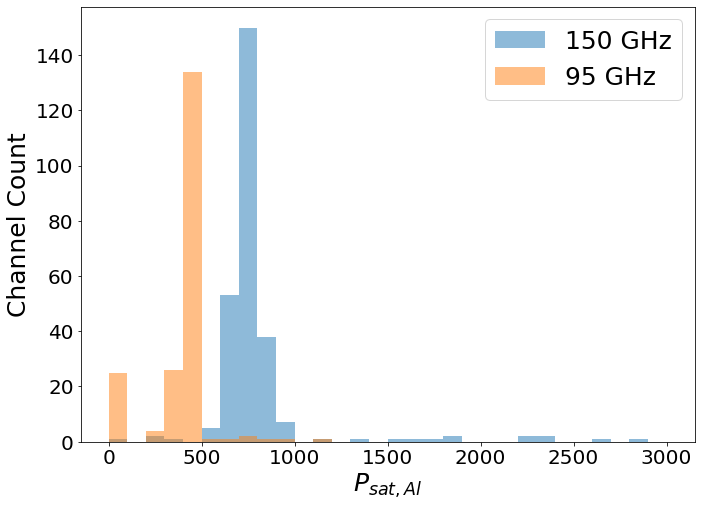

In [7]:
datafiles = glob.glob('./20240213_processed_load_curve_data/[!testing]*')

GHz150_Warm_Psat = np.array([])
GHz150_Cold_Psat = np.array([])
GHz95_Warm_Psat = np.array([])
GHz95_Cold_Psat = np.array([])

for pickle_i in datafiles:
    temp = pickle_i.split('_')[-1].split('.')[0]
    ASU_BL = int(pickle_i.split('_')[-2].split('L')[1])
    
    #print(temp, ASU_BL)
    
    with open(pickle_i, 'rb') as f:
        data_i = pickle.load(f) 
        
    if temp == 'Warm':
        if np.in1d(ASU_BL, GHz150_lines)[0]:
            for ch in range(len(data_i['Vtes'])):
                split_pt = int(len(data_i['bps'][ch])/3)
                Psat_index = dm.find_nearest_idx(data_i['bps'][ch][split_pt:]*100, 90)
                GHz150_Warm_Psat = np.append(GHz150_Warm_Psat, data_i['Pbias'][ch][split_pt+Psat_index])
                                           
        if np.in1d(ASU_BL, GHz95_lines)[0]:
            for ch in range(len(data_i['Vtes'])):
                split_pt = int(len(data_i['bps'][ch])/3)
                Psat_index = dm.find_nearest_idx(data_i['bps'][ch][split_pt:]*100, 90)
                GHz95_Warm_Psat = np.append(GHz95_Warm_Psat, data_i['Pbias'][ch][split_pt+Psat_index])
     
    if temp == 'Cold':
        if np.in1d(ASU_BL, GHz150_lines)[0]:
            for ch in range(len(data_i['Vtes'])):
                split_pt = int(len(data_i['bps'][ch])/3)
                Psat_index = dm.find_nearest_idx(data_i['bps'][ch][split_pt:]*100, 90)
                GHz150_Cold_Psat = np.append(GHz150_Cold_Psat, data_i['Pbias'][ch][split_pt+Psat_index])
                                           
        if np.in1d(ASU_BL, GHz95_lines)[0]:
            for ch in range(len(data_i['Vtes'])):
                split_pt = int(len(data_i['bps'][ch])/3)
                Psat_index = dm.find_nearest_idx(data_i['bps'][ch][split_pt:]*100, 90)
                GHz95_Cold_Psat = np.append(GHz95_Cold_Psat, data_i['Pbias'][ch][split_pt+Psat_index])
                                          

fig_95_Psat, ax_95_Psat = plt.subplots(1, figsize=(14, 10))                    
                    
ax_95_Psat.hist(GHz95_Warm_Psat,30,label='150 GHz, 293 K')
ax_95_Psat.hist(GHz95_Cold_Psat,30,alpha=0.5,label='150 GHz, 77 K')

ax_95_Psat.set_xlabel('$P_{sat}$ (pW)',fontsize=25)
ax_95_Psat.set_ylabel('$N$',fontsize=25)
ax_95_Psat.set_title('Bias Lines 08, 09\n$T_{bath}$ = 330 mK',fontsize=25)
ax_95_Psat.legend(fontsize=25)
ax_95_Psat.tick_params(axis='both', which='major', labelsize=20)
ax_95_Psat.ticklabel_format(useOffset=False)
ax_95_Psat.ticklabel_format(style='plain')

fig_150_Psat, ax_150_Psat = plt.subplots(1, figsize=(14, 10))

ax_150_Psat.hist(GHz150_Warm_Psat,30,label='95 GHz, 293 K')
ax_150_Psat.hist(GHz150_Cold_Psat,30,alpha=0.5,label='95 GHz, 77 K')

ax_150_Psat.set_xlabel('$P_{sat}$ (pW)',fontsize=25)
ax_150_Psat.set_ylabel('$N$',fontsize=25)
ax_150_Psat.set_title('Bias Lines 06, 07, 10, 11\n$T_{bath}$ = 330 mK',fontsize=25)
ax_150_Psat.legend(fontsize=25)
ax_150_Psat.tick_params(axis='both', which='major', labelsize=20)
ax_150_Psat.ticklabel_format(useOffset=False)
ax_150_Psat.ticklabel_format(style='plain')

fig_combined_300K, ax_combined_300K = plt.subplots(1, figsize=(11,8))
ax_combined_300K.hist(GHz150_Warm_Psat,30,range=(0,3000),label='150 GHz',alpha=0.5)#histtype=u'step')
ax_combined_300K.hist(GHz95_Warm_Psat,30,range=(0,3000),label='95 GHz',alpha=0.5)#,histtype=u'step')
ax_combined_300K.set_xlabel('$P_{sat,Al}$',fontsize=25)
ax_combined_300K.set_ylabel('Channel Count',fontsize=25)
ax_combined_300K.tick_params(axis='both', which='major', labelsize=20)
ax_combined_300K.legend(fontsize=25)

fig_combined_300K.savefig('./SPIE_2024_Figures/Psat_Hist.png',dpi=150)



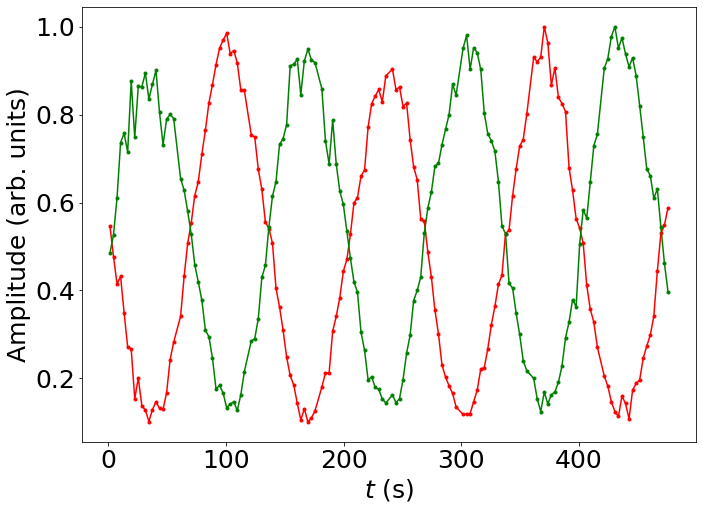

In [8]:
#Polarization

polarization_1 = pd.read_csv('./SPIE_2024_Figures/polarization_1_2in_aperture_channel_131.csv',sep=',')
polarization_2 = pd.read_csv('./SPIE_2024_Figures/polarization_2_2in_aperture_channel_134.csv',sep=',')

fig, ax = plt.subplots(1,figsize=(11,8))
ax.plot(polarization_1['t (s)'], polarization_1['Phase (nPhi0)']/np.max(polarization_1['Phase (nPhi0)']),'r.-')
ax.plot(polarization_2['t (s)'], polarization_2['Phase (nPhi0)']/np.max(polarization_2['Phase (nPhi0)']),'g.-')
ax.set_xlabel('$t$ (s)',fontsize=25)
ax.set_ylabel('Amplitude (arb. units)',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=25)
fig.savefig('./SPIE_2024_Figures/Polarization_Rough',dpi=120)




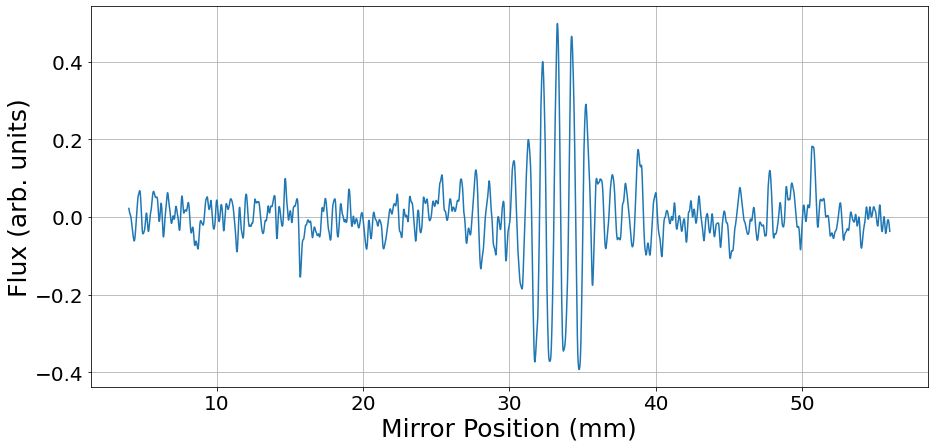

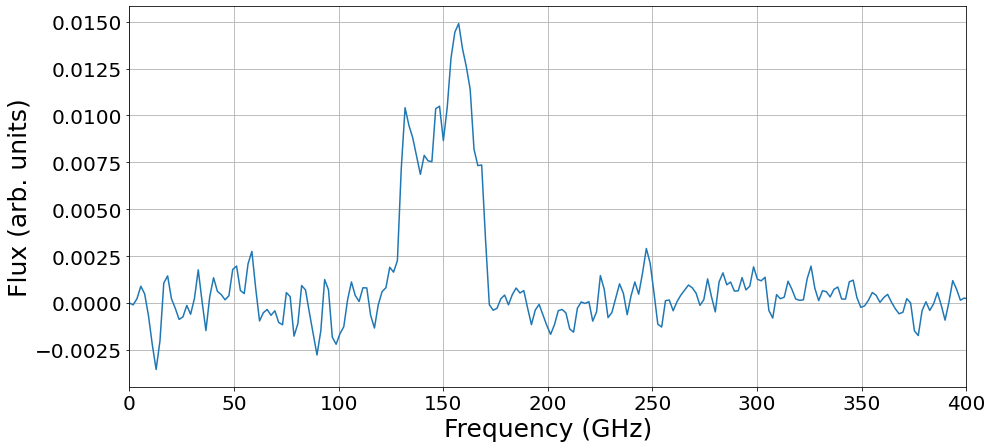

In [10]:
#FTS 150 GHz

interferogram_file = 'fts_150GHz_interferogram20240611.csv'
spectrum_file = 'fts_150GHz_spectrum20240611.csv'

interferogram_df = pd.read_csv(interferogram_file,sep=',',header=None)
spectrum_df = pd.read_csv(spectrum_file,sep=',',header=None)

#print(interferogram_df)
#print(spectrum_df)

fig, ax = plt.subplots(1, figsize=(15,7))
ax.plot(interferogram_df[0],interferogram_df[1])
ax.set_xlabel('Mirror Position (mm)',fontsize=25)
ax.set_ylabel('Flux (arb. units)',fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.grid()
fig.savefig('./SPIE_2024_Figures/150GHz_Interferogram',dpi=120)


fig2,ax2 = plt.subplots(1, figsize=(15,7))
ax2.plot(spectrum_df[0], spectrum_df[1])
ax2.set_xlabel('Frequency (GHz)',fontsize=25)
ax2.set_ylabel('Flux (arb. units)',fontsize=25)
ax2.set_xlim([0,400])
ax2.tick_params(axis='both', which='major', labelsize=20)
ax2.grid()
fig2.savefig('./SPIE_2024_Figures/150GHz_Spectrum',dpi=120)